In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import cv2
import os
import time
import math
import main_functions as main

In [3]:
def visualize_confusion_matrix(confusion, accuracy, label_classes, name):
    plt.title("{}, accuracy = {:.3f}".format(name, accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.show()

In [4]:
mnist_train = sio.loadmat('./mnist_train.mat')
mnist_test = sio.loadmat('./mnist_test.mat')
im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
batch_size = 32
im_train, im_test = im_train / 255.0, im_test / 255.0

# SLP Linear

In [5]:
def get_mini_batch(im_train, label_train, batch_size):
    ## For ease of batching
    im_swp = np.swapaxes(im_train,0,1)
    lab_swp = np.swapaxes(label_train,0,1)
    
    ## One hot encoding
    oh_lab_swp = []
    for lab in lab_swp:
        oh = np.zeros(10)
        oh[lab] = 1
        oh_lab_swp.append(oh)
    
    seed = 527
    np.random.seed(seed)
    np.random.shuffle(im_swp)
    np.random.seed(seed)
    np.random.shuffle(oh_lab_swp)
    
    mini_batch_x = np.array(np.array_split(im_swp,batch_size))#.reshape((-1,196,32))
    mini_batch_y = np.array(np.array_split(oh_lab_swp,batch_size))#.reshape((-1,10,32))
    
    return mini_batch_x,mini_batch_y

In [6]:
def fc(x, w, b):
    if len(x.shape) > 1:
        x = x.flatten()
    y = np.dot(w,x) + b
    
    return y

In [7]:
def loss_euclidian(y_tilde, y):
    l = np.linalg.norm(y_tilde-y)**2
    dl_dy = 2*(y_tilde-y)
    
    return l, dl_dy

In [8]:
def fc_backward(dl_dy, x, w, b, y):
    dl_dx = np.dot(w.T,dl_dy)
    dl_dw = np.outer(dl_dy,x)
    dl_db = dl_dy

    return dl_dx, dl_dw, dl_db

In [9]:
def train_slp_linear(mini_batch_x, mini_batch_y):
    batch_size,batches,size_img = mini_batch_x.shape
    n = 10
    m = size_img
    lr = 1e-4
    dr = 0.9
    w = np.random.normal(0, 1, size=(n,m))
    b = np.zeros((n))
    k = 0

    for itr in range(10000):
        if itr % 1000 == 0:
            lr *= dr

        dl_dw = 0
        dl_db = 0

        for i in range(batch_size):
            x = mini_batch_x[:,k][i]
            y = mini_batch_y[:,k][i]
            
            y_tilde = fc(x, w, b)
            l,dl_dy = loss_euclidian(y_tilde, y)
            dl_dx, dl_dw_n, dl_db_n = fc_backward(dl_dy, x, w, b, y)

            dl_dw += dl_dw_n
            dl_db += dl_db_n

        k += 1
        if k >= batches:
            k = 0

        w -= (lr * dl_dw)
        b -= (lr * dl_db)
        
    return w,b

In [10]:
#main.main_slp_linear()

# SLP 

In [11]:
def loss_cross_entropy_softmax(x, y):
    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x))
    
    l = -1 * (np.sum(y*np.log(1e-9 + softmax(x))) / len(y))
    dl_dy = softmax(x) - y
    
    return l, dl_dy

In [12]:
def train_slp(mini_batch_x, mini_batch_y):
    batch_size,batches,size_img = mini_batch_x.shape
    n = 10
    m = size_img
    lr = 1e-3
    dr = 0.9
    w = np.random.normal(0, 0.5, size=(n,m))
    b = np.zeros((n))
    k = 0

    for itr in range(10000):
        if itr % 1000 == 0:
            lr *= dr

        dl_dw = 0
        dl_db = 0

        for i in range(batch_size):
            x = mini_batch_x[:,k][i]
            y = mini_batch_y[:,k][i]
            
            fc_out = fc(x, w, b)
            l,dl_dy = loss_cross_entropy_softmax(fc_out, y)
            dl_dx, dl_dw_n, dl_db_n = fc_backward(dl_dy, x, w, b, y)

            dl_dw += dl_dw_n
            dl_db += dl_db_n

        k += 1
        if k >= batches:
            k = 0

        w -= (lr * dl_dw)
        b -= (lr * dl_db)
        
    return w,b

In [13]:
#main.main_slp()

# MLP

In [727]:
def relu(x):
    return np.maximum(x*1e-2,x)

In [728]:
def relu_backward(dl_dy, x, y):
    dl_dx = (x > 0).astype(int)
    return np.where(dl_dx==0., 0.01, dl_dx)

In [729]:
mini_batch_x,mini_batch_y = get_mini_batch(im_train, label_train, batch_size)

In [730]:
import time as t

In [731]:
batch_size,batches,size_img = mini_batch_x.shape
n = 10
m = size_img
lr = 1e-3
dr = 0.9
w1 = np.random.normal(0, 1, size=(30,196))
w2 = np.random.normal(0, 1, size=(10,30))
b1 = np.zeros((30))
b2 = np.zeros((10))
k = 0
_ = None

st = t.time()

for itr in range(60000):

    if itr % 1000 == 0: 
        lr *= dr

    if itr % 10000 == 0:
        end = t.time()
        print(end-st)
        st = t.time()
        print(itr)

    dl_dw_1 = 0
    dl_dw_2 = 0
    dl_db_1 = 0
    dl_db_2 = 0

    for i in range(batch_size):
        x = mini_batch_x[:,k][i]
        y = mini_batch_y[:,k][i]
        
        ## Forward
        fc_1 = fc(x, w1, b1)
        relu_ = relu(fc_1)
        fc_2 = fc(relu_, w2, b2)
        l,dl_dy = loss_cross_entropy_softmax(fc_2, y)
        
        ## Backward
        dl_dx_2, dl_dw_n_2, dl_db_n_2 = fc_backward(dl_dy, relu_, w2, _, _)  
        dl_dx_relu = relu_backward(dl_dx_2, fc_1, _)
        dl_dx_1, dl_dw_n_1, dl_db_n_1 = fc_backward(dl_dx_relu, x, w1, _, _)

        dl_dw_1 += dl_dw_n_1
        dl_db_1 += dl_db_n_1
        dl_dw_2 += dl_dw_n_2
        dl_db_2 += dl_db_n_2

    k += 1
    if k >= batches:
        k = 0

    w1 -= (lr * dl_dw_1)
    b1 -= (lr * dl_db_1)
    w2 -= (lr * dl_dw_2)
    b2 -= (lr * dl_db_2)


0.0010027885437011719
0
29.65001630783081
10000
29.685959815979004
20000
29.66893768310547
30000
29.93994450569153
40000
29.784934759140015
50000


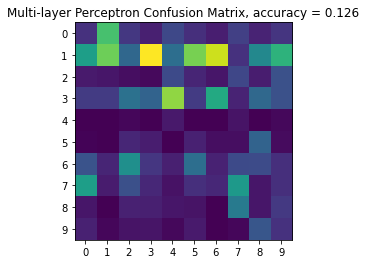

In [732]:
mnist_train = sio.loadmat('./mnist_train.mat')
mnist_test = sio.loadmat('./mnist_test.mat')
im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
batch_size = 32
im_train, im_test = im_train / 255.0, im_test / 255.0
mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
#w1, b1, w2, b2 = train_mlp(mini_batch_x, mini_batch_y)
sio.savemat('mlp.mat', mdict={'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2})

acc = 0
confusion = np.zeros((10, 10))
num_test = im_test.shape[1]
for i in range(num_test):
    x = im_test[:, [i]]
    pred1 = fc(x, w1, b1)
    pred2 = relu(pred1)
    y = fc(pred2, w2, b2)
    l_pred = np.argmax(y)
    confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

    if l_pred == label_test[0, i]:
        acc = acc + 1
accuracy = acc / num_test
for i in range(10):
    confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
visualize_confusion_matrix(confusion, accuracy, label_classes, 'Multi-layer Perceptron Confusion Matrix')

# CNN

In [468]:
## Copied from 
## https://leonardoaraujosantos.gitbook.io/artificial-inteligence
## /machine_learning/deep_learning/convolution_layer/making_faster#im2col-and-col2im-sources-in-python
def im2col(x,hh,ww,stride):
    """
    Args:
      x: image matrix to be translated into columns, (C,H,W)
      hh: filter height
      ww: filter width
      stride: stride
    Returns:
      col: (new_h*new_w,hh*ww*C) matrix, each column is a cube that will convolve with a filter
            new_h = (H-hh) // stride + 1, new_w = (W-ww) // stride + 1
    """
    c,h,w = x.shape
    new_h = (h-hh) // stride + 1
    new_w = (w-ww) // stride + 1
    col = np.zeros([new_h*new_w,c*hh*ww])
    for i in range(new_h):
       for j in range(new_w):
           patch = x[...,i*stride:i*stride+hh,j*stride:j*stride+ww]
           col[i*new_w+j,:] = np.reshape(patch,-1)
    return col

In [469]:
def conv(x, w_conv, b_conv):
    x = np.array([np.pad(x.reshape((14,14)),1,'constant')])
    X = im2col(x,3,3,1)
    y = X.dot(w_conv.reshape(9,-1)) + b_conv.reshape(3)

    return y.reshape(14,14,-1)

In [548]:
def conv_backward(dl_dy, x, w_conv, b_conv, y):
    ## Assuming x is result from conv layer 
    dl_db = np.sum(dl_dy.reshape(-1,3),axis=0)
    dl_dw = dl_dy * x
    
    return dl_dw, dl_db

In [716]:
def pool2x2(x):
    out = [[0 for i in range(7)] for i in range(7)]
    wk = x.reshape((14,14))
    for i in range(0,14,2):
        for j in range(0,14,2):
            wnd = wk[i:i+2,j:j+2]
            out[i//2][j//2] = np.max(wnd)
            
    return np.array(out).reshape((7,7,1))

In [717]:
def pool2x2_backward(dl_dy, x, y):
    out = [[0 for i in range(14)] for i in range(14)]
    wk = x.reshape((14,14))
    for i in range(0,14,2):
        for j in range(0,14,2):
            wnd = wk[i:i+2,j:j+2]
            xx,yy = np.unravel_index(wnd.argmax(), wnd.shape)
            out[i+xx][j+yy] = np.max(wnd)
            
    return np.array(out)

In [726]:
def flattening(x):
    return np.ravel(x, order='F')

In [734]:
def flattening_backward(dl_dy, x, y):
    return None

In [719]:
h,w,c1,c2 = 14,14,1,3
x = np.random.normal(0,1,size=(h,w,c1))
w_conv = np.random.normal(1,0.1,size=(3,3,1,3))
b_conv = np.random.normal(0,0.1,size=(c2,1))

y = conv(x, w_conv, b_conv)
l,dl_dy = loss_cross_entropy_softmax(x,y)
dl_dw, dl_db = conv_backward(dl_dy, x, w_conv, b_conv, y)
pool = pool2x2(x)
back = pool2x2_backward(dl_dy, x, y)

In [ ]:
mini_batch_x,mini_batch_y = get_mini_batch(im_train, label_train, batch_size)

In [ ]:
batch_size,batches,size_img = mini_batch_x.shape
n = 10
m = size_img
lr = 1e-3
dr = 0.9
h,w,c1,c2 = 14,14,1,3
w_conv = np.random.normal(0,0.1,size=(3,3,1,3))
b_conv = np.random.normal(0,0.1,size=(c2,1))
w_fc = np.random.normal(0,0.1,size=(10,147))
b_fc = np.random.normal(0,0.1,size=(10,1))
k = 0
_ = None

st = t.time()

for itr in range(5000):
    if itr % 1000 == 0: 
        lr *= dr

    if itr % 10000 == 0:
        end = t.time()
        print(end-st)
        st = t.time()
        print(itr)

    dl_dw_1 = 0
    dl_dw_2 = 0
    dl_db_1 = 0
    dl_db_2 = 0

    for i in range(batch_size):
        x = mini_batch_x[:,k][i]
        y = mini_batch_y[:,k][i]
        
        ## Forward
        conv_1 = conv(x, w_conv, b_conv)
        relu_1 = relu(conv_1)
        pooled = pool2x2(relu_1)
        flattened = flattening(pooled)
        fc_1 = fc(flattened, w_fc, b_fc)
        l,dl_dy = loss_cross_entropy_softmax(fc_1,y)
        
        ## Backward
        dl_dx_2, dl_dw_n_2, dl_db_n_2 = fc_backward(dl_dy, flattened, w_fc, b_fc, y)  
        dl_dx_1 = flattening_backward(dl_dy, pooled, y)
        pool_back = pool2x2_backward(dl_dy, relu_1, y)
        relu_back = relu_backward(dl_dy, conv_1, y)
        conv_back = conv_backward(dl_dy, x, w_conv, b_conv, y)
        
        
## TODO

    k += 1
    if k >= batches:
        k = 0

## TODO
